# Example notebook for using RS propagation from propagate module 

In the following we exemplify Rayleigh-Sommerfeld (RS) propagation from elements via the ``generate`` module illuminated with plane waves, using the ``propagate`` module. In particular:

* Several examples of RS propagations in Z axis, YZ and XY planes:

    * RS propagation from elements defined from library functions apertures (e.g. Fresnel lenses)
    
    * RS propagation from elements defined from arbitrarily defined functions (e.g. Spiral Phase Plate)

In the ``propagate`` module, Rayleigh-Sommerfeld propagation is implemented via direct numerical integration of a double integral (see, e.g. Goodman Fourier Optics textbook as reference), making it (very) time-consuming, yet exact. 

Fresnel and Fraunhofer propagations provide acceptable approximations with faster computation for the propagation in some ranges. In the ``propagate`` module these approximations have been implemented following the Goodman Fourier Optics textbook. For simple use examples of Fresnel and Fraunhofer propagations check propopt package https://github.com/cunhaJ/propopt .
    

In [1]:
# Notebook display options, change as your preference/system
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w",'bbox_inches':None}

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [2]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

from matplotlib import pyplot as plt 
import numpy as np 

from scipy.constants import micro, nano, milli

import pyMOE as moe 
from pyMOE.generate import *  
from pyMOE.propagate import * 

## Propagation from a circular aperture

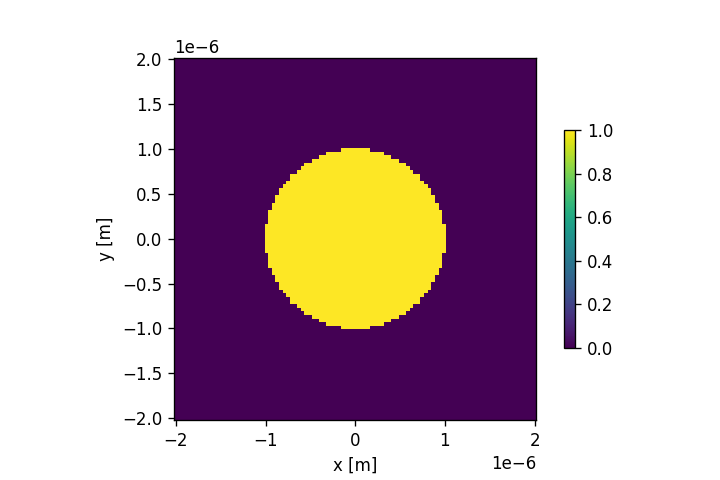

In [3]:
# Make circular apertures (returns also the 2D array)

wavelength = 400e-9 #m
zdist = 100*wavelength #m
 
pixsize = 0.1 * wavelength
x_pixel = 100
y_pixel = 100
 
aperture_width  = x_pixel*pixsize
aperture_height = y_pixel*pixsize

radius = 1000e-9 #m 

# Define Aperture
aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel)

# Populate Aperture from phase mask 
mask = moe.generate.circular_aperture(aperture, radius=radius)

# Define Phase mask 
mask_phase = moe.generate.create_empty_aperture_from_aperture(aperture)
mask_phase.aperture = mask.aperture*np.pi


# Plot the circular mask
moe.plotting.plot_aperture(mask)


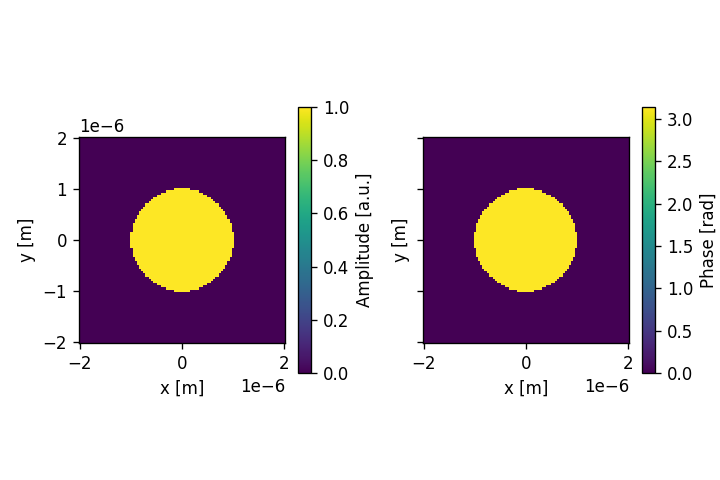

In [4]:
# Calculates a field to use with the calculated mask

# Initialize a Field from the Aperture mask 
field = moe.field.create_empty_field_from_aperture(mask)

# Generate a uniform field
field = moe.field.generate_uniform_field(field, E0=1)

# Or Gaussian field is also available 
#field = moe.field.generate_gaussian_field(field, E0=1, w0=100*micro)

# Modulates the field with a given aperture that can be used either as an amplitude mask or a phase mask
field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=mask_phase)

# Plots the field (amplitude and phase)
moe.plotting.plot_field(field)

plt.tight_layout()
plt.show()


In [5]:
####Propagate field and calculate in plane YZ, using npix bins in Y
zmin = wavelength
zmax = 0.2*zdist
nzs = 200

# Creates a screen in YZ plane with [-aperture_height/2, aperture_height/2] and [zmin, zmax] and 
screen_YZ = moe.field.create_screen_YZ(-aperture_height/2, aperture_height/2, y_pixel, 
                                        zmin, zmax, nzs,
                                        x=0)

# Propagate the field 
E_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, simp2d=True)

[########################################] | 100% Completed | 45.5s


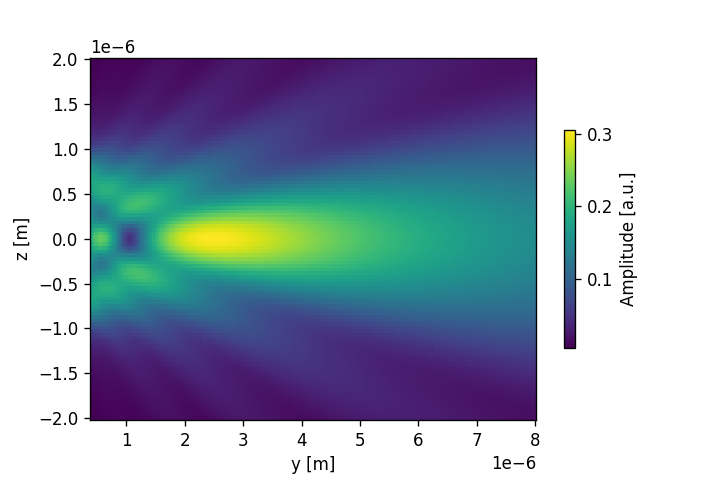

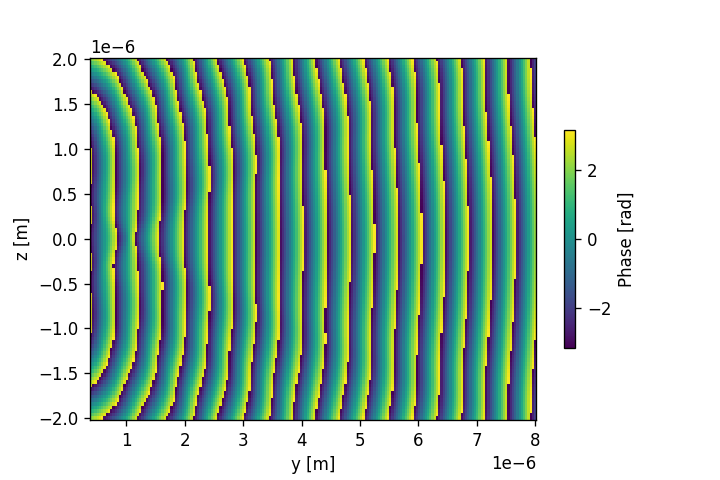

In [6]:
#Plot the amplitude of the propagated field in yz screen
moe.plotting.plot_screen_YZ(E_YZ, which='amplitude')
plt.show()

#Plot the phase of the propagated field in yz screen
moe.plotting.plot_screen_YZ(E_YZ, which='phase')
plt.show()

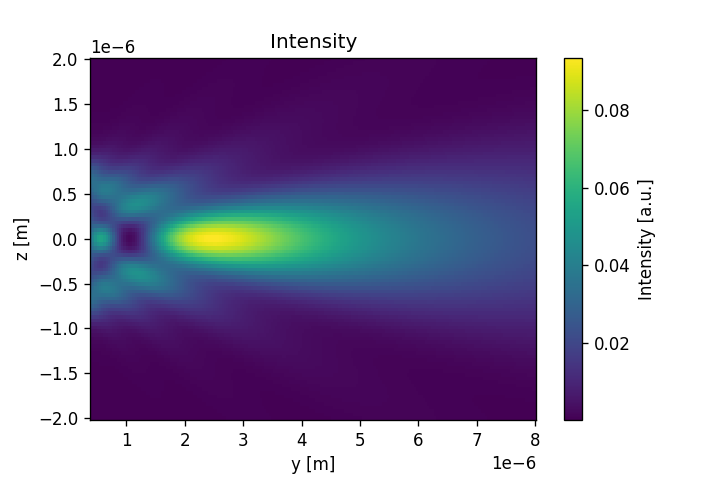

In [7]:
###Plot intensity in the YZ screen
I_YZ= E_YZ 
I_YZ.screen= np.abs(E_YZ.amplitude)**2 ## careful with multiple assertions this way

moe.plotting.plot_screen_YZ(I_YZ, which='amplitude', colorbar=False)
plt.colorbar(label='Intensity [a.u.]')
plt.title("Intensity")
plt.show()


## Propagation from a Fresnel multilevel mask example #1

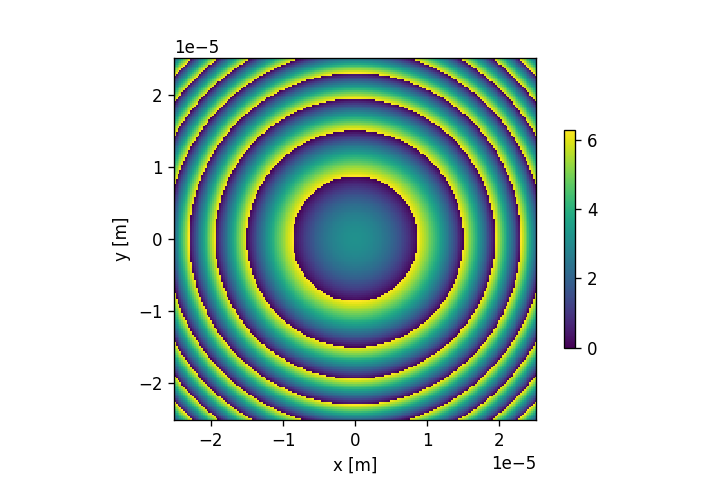

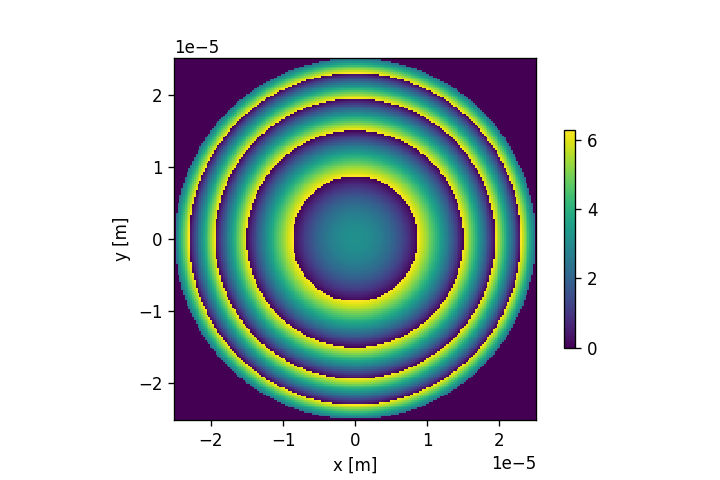

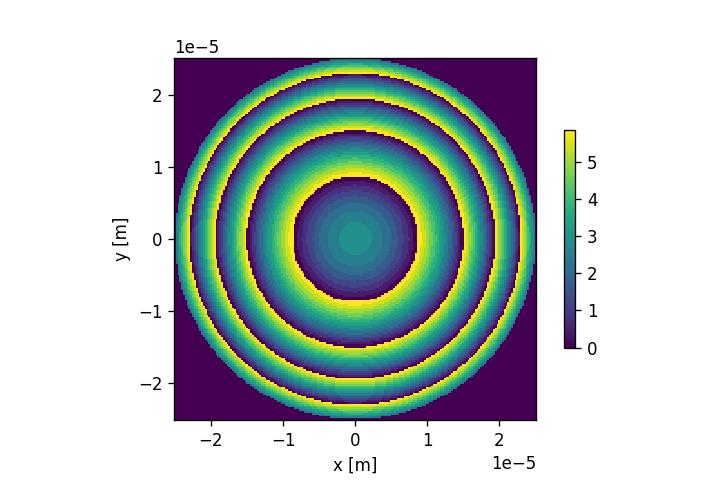

In [8]:
#number of pixels 
x_pixel = 200
y_pixel = 200

#size of the rectangular mask 
aperture_width  = 50e-6 #m
aperture_height = 50e-6

pixsize = 1e-6 #m

wavelength = 500e-9 #m
focal_length = 150e-6

zmin = wavelength
zmax = 1.2* focal_length
nzs = 500

radius = aperture_width/2 

# Create Aperture
aperture1 = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel)

# Populate Aperture with Fresnel mask 
mask1 = moe.generate.fresnel_phase(aperture1, focal_length, wavelength )

moe.plotting.plot_aperture(mask1)


##############
###Fresnel mask with a truncated circular aperture 

# Create empty mask
aperture2 = moe.generate.create_empty_aperture_from_aperture(aperture1)

# and truncate around radius
mask2 = moe.generate.fresnel_phase(aperture2, focal_length, wavelength, radius=radius)
moe.plotting.plot_aperture(mask2)

# Discretize mask in number of levels
# Select exact position of contours  in phase
phase_vals = np.linspace(0, 2*np.pi, 16)

mask2.discretize(np.array( phase_vals)[:] ) 
moe.plotting.plot_aperture(mask2)


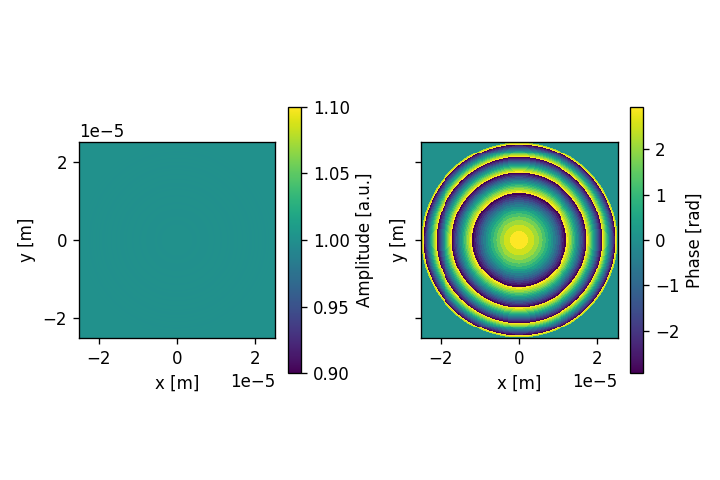

In [9]:
# Generate a uniform field
field = moe.field.create_empty_field_from_aperture(mask2)

field = moe.field.generate_uniform_field(field, E0=1)

# Modulates the field 
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask2)

# Plots the field (amplitude and phase)
moe.plotting.plot_field(field)

plt.tight_layout()
plt.show()


In [10]:
##Propagate field in plane XY at z_distance

z_distance = focal_length 

# Creates XY screen
screen_XY = moe.field.create_screen_XY(-aperture_width/2, aperture_width/2, x_pixel, 
                                       -aperture_height/2, aperture_height/2, y_pixel, 
                                        z=z_distance)

# Propagate the field
E_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, simp2d=True)


[########################################] | 100% Completed |  2min 34.3s


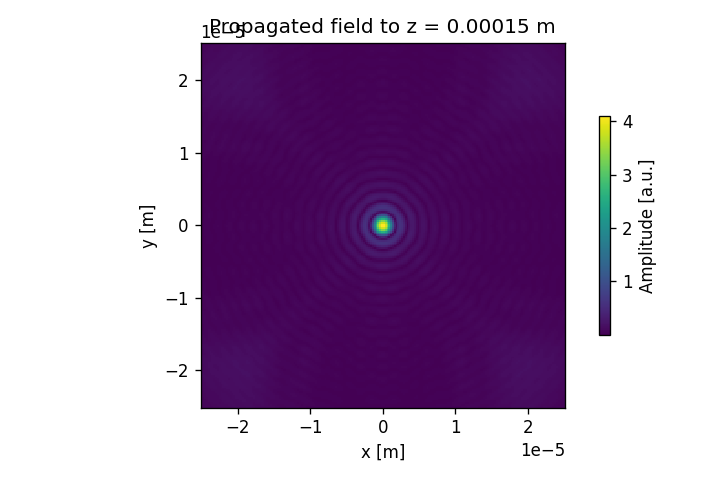

<Figure size 720x480 with 0 Axes>

In [11]:
# Plot the amplitude of the propagated field in XY screen

moe.plotting.plot_screen_XY(E_XY, which='amplitude')
plt.title("Propagated field to z = "+str(z_distance)+" m")

plt.tight_layout()
plt.show()

plt.savefig("FresnelN16-XY.png")

In [12]:
#### Propagate field and calculate in plane YZ, using 100 bins in Y

nbins_y= 100

# Creates YZ screen
screen_YZ = moe.field.create_screen_YZ(-aperture_height/2, aperture_height/2, nbins_y, 
                                        zmin, zmax, nzs,
                                        x=0)

# Propagate the field 
E_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, simp2d=True)


[########################################] | 100% Completed |  3min  4.0s


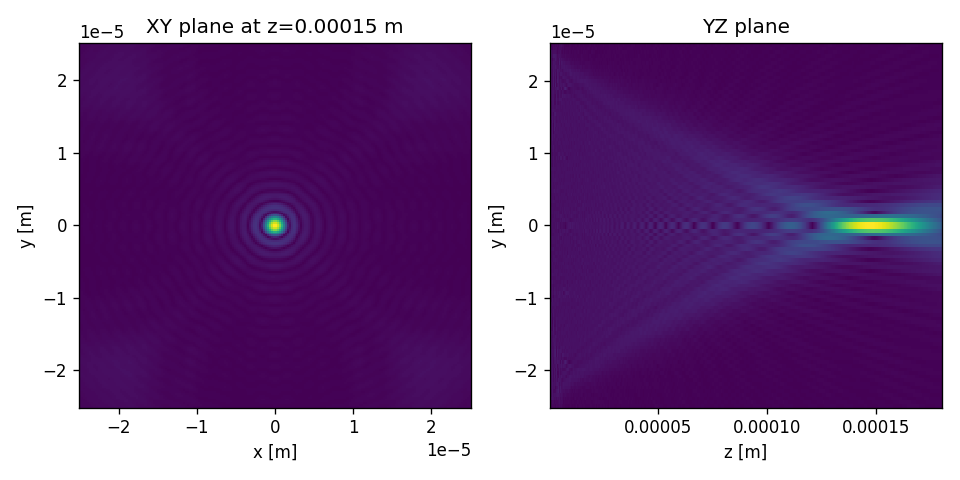

In [13]:
###Plot the two fields in same panel 
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


z1 = E_XY.amplitude.reshape(len(E_XY.x),len(E_XY.y))
xp1 = np.linspace(-aperture_width/2 ,aperture_width/2, z1.shape[0])
yp1 = np.linspace(-aperture_height/2,aperture_height/2,z1.shape[1])

z2 = E_YZ.amplitude.reshape(len(E_YZ.y),len(E_YZ.z))
yp2 = np.linspace(-aperture_height/2 ,aperture_height/2,nbins_y)
zp2 = np.linspace(zmin,zmax,nzs)

ax1.title.set_text('XY plane at z='+str(focal_length)+' m')
ax1.pcolormesh(xp1,yp1,np.abs(z1) )
ax2.title.set_text('YZ plane')
ax2.pcolormesh(zp2,yp2,np.abs(z2) )


ax1.set(xlabel="x [m]", ylabel="y [m]")
ax2.set(xlabel="z [m]", ylabel="y [m]")

plt.tight_layout()

[########################################] | 100% Completed |  2.7s


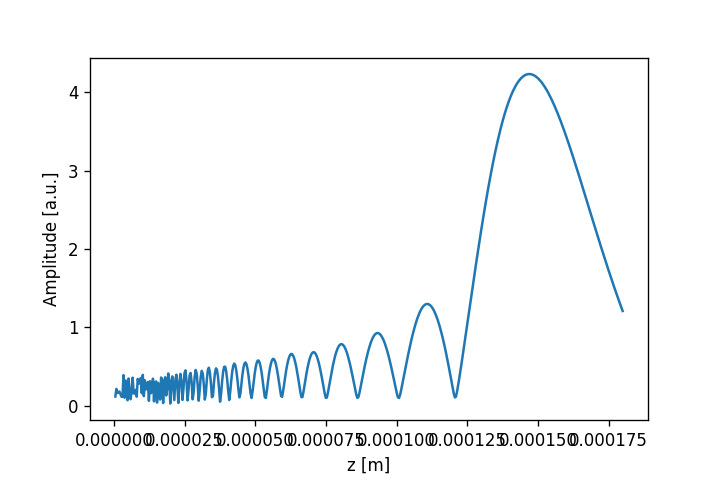

In [14]:
# Propagates the field in a single line along the Z axis
screen_ZZ = moe.field.create_screen_ZZ(zmin, zmax, nzs)
screen_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength, parallel_computing=True)

moe.plotting.plot_screen_ZZ(screen_ZZ, which='amplitude')

In [15]:
##Propagate field using RS integral using smaller bins 
#-> Results in a faster calculation just for fast inspection, however, use with care, due to possible bluring effects
nbins_y = 25

screen_YZ = moe.field.create_screen_YZ(-aperture_height/2, aperture_height/2, nbins_y, 
                                        zmin, zmax, nzs,
                                        x=0)
screen_XY = moe.field.create_screen_XY(-aperture_width/2, aperture_width/2, nbins_y, 
                                       -aperture_height/2, aperture_height/2, nbins_y, 
                                        z=z_distance)

E_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, simp2d=True)
E_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, simp2d=True)


[########################################] | 100% Completed | 45.5s
[########################################] | 100% Completed |  2.4s


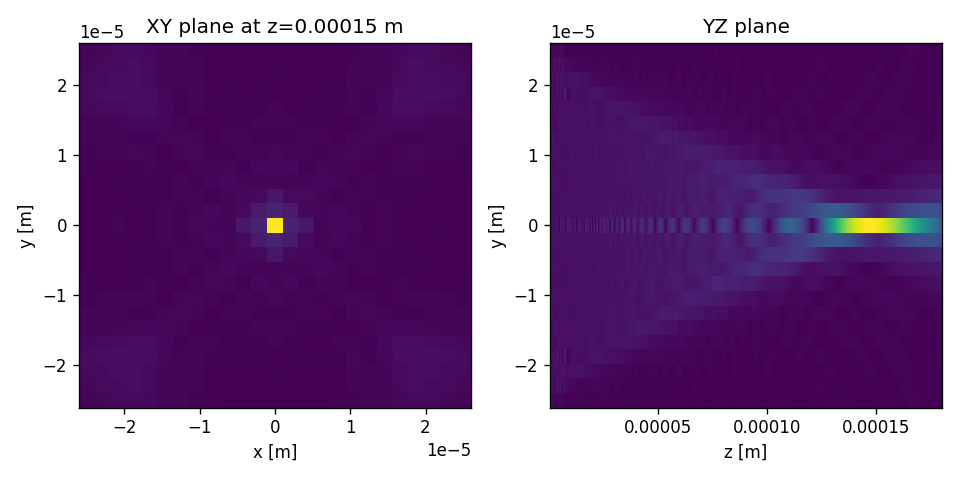

In [16]:
###Plot the two fields in same panel 
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


z1 = E_XY.amplitude.reshape(len(E_XY.x),len(E_XY.y))
xp1 = np.linspace(-aperture_width/2 ,aperture_width/2, z1.shape[0])
yp1 = np.linspace(-aperture_height/2,aperture_height/2,z1.shape[1])

z2 = E_YZ.amplitude.reshape(len(E_YZ.y),len(E_YZ.z))
yp2 = np.linspace(-aperture_height/2 ,aperture_height/2,nbins_y)
zp2 = np.linspace(zmin,zmax,nzs)

ax1.title.set_text('XY plane at z='+str(focal_length)+' m')
ax1.pcolormesh(xp1,yp1,np.abs(z1) )
ax2.title.set_text('YZ plane')
ax2.pcolormesh(zp2,yp2,np.abs(z2) )


ax1.set(xlabel="x [m]", ylabel="y [m]")
ax2.set(xlabel="z [m]", ylabel="y [m]")

plt.tight_layout()

## Propagation from a Fresnel multilevel mask example #2

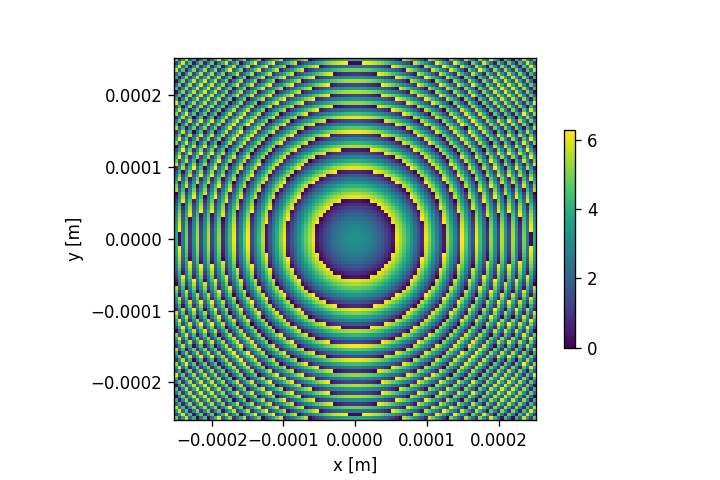

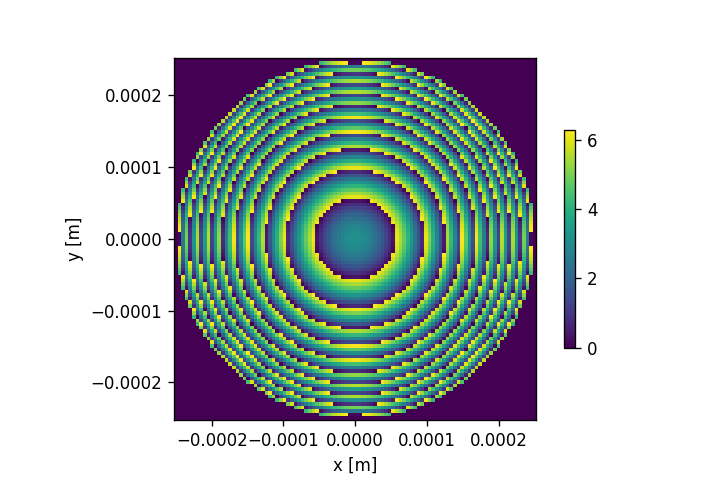

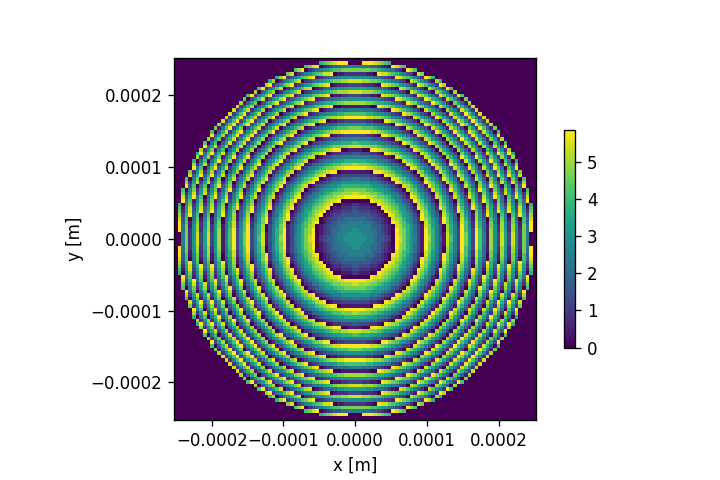

In [17]:
### Here we will apply same strategy with functions from pyMOE v1.3 

#number of pixels 
x_pixel = 100
y_pixel = 100

#size of the rectangular mask 
aperture_width  = 500e-6 #m
aperture_height = 500e-6

pixsize = aperture_width/x_pixel #m

wavelength = 632.8e-9 #m
focal_length = 5000e-6

zmin = wavelength
zmax = 1.2* focal_length
nzs = 500

radius = aperture_width/2 

# Create Aperture
aperture1 = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel)

# Populate Aperture with Fresnel mask 
mask1 = moe.generate.fresnel_phase(aperture1, focal_length, wavelength )

moe.plotting.plot_aperture(mask1)


##############
###Fresnel mask with a truncated circular aperture 

# Create empty mask
aperture2 = moe.generate.create_empty_aperture_from_aperture(aperture1)

# and truncate around radius
mask2 = moe.generate.fresnel_phase(aperture2, focal_length, wavelength, radius=radius)
moe.plotting.plot_aperture(mask2)

# Discretize mask in number of levels
# Select exact position of contours  in phase
phase_vals = np.linspace(0, 2*np.pi, 16)

mask2.discretize(np.array( phase_vals)[:] ) 
moe.plotting.plot_aperture(mask2)


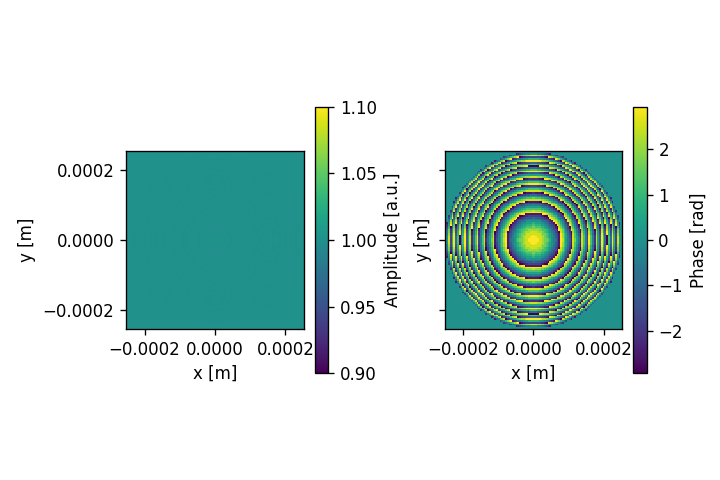

In [18]:
# Generate a uniform field
field = moe.field.create_empty_field_from_aperture(mask2)

field = moe.field.generate_uniform_field(field, E0=1)

# Modulates the field 
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask2)

# Plots the field (amplitude and phase)
moe.plotting.plot_field(field)

plt.tight_layout()
plt.show()


In [19]:
RS_resultsxy = moe.propagate.RS_intXY(focal_length, field.field, x_pixel, pixsize, x_pixel*4, aperture_width/2, aperture_width/2, wavelength, verbose=True)
z1 = RS_resultsxy[0] ##E field


RS_resultsyz = moe.propagate.RS_intYZ(zmin,zmax,nzs,0, field.field, x_pixel, pixsize, x_pixel, aperture_width/2, aperture_width/2, wavelength, 1, verbose=True)
z2 = RS_resultsyz[0] ##E field 

Progress: [####################] 100.0%
Elapsed: 0:05:43.116172
Progress: [####################] 100.0%
Elapsed: 0:01:40.152807


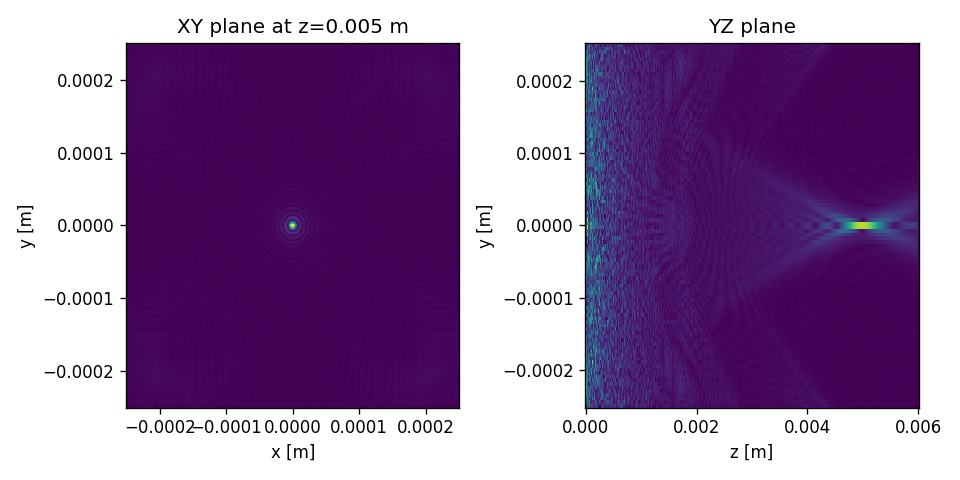

In [20]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xp1 = np.linspace(-aperture_width/2, aperture_width/2,z1.shape[0])
yp1 = np.linspace(-aperture_height/2, aperture_height/2,z1.shape[1])

yp2 = np.linspace(-aperture_width/2, aperture_width/2,z2.shape[0])
zp2 = np.linspace(zmin,zmax,nzs)

ax1.title.set_text('XY plane at z='+str(focal_length)+' m')
ax1.pcolormesh(xp1,yp1,np.abs(z1) )
ax2.title.set_text('YZ plane')
ax2.pcolormesh(zp2,yp2,np.abs(z2) )


ax1.set(xlabel="x [m]", ylabel="y [m]")
ax2.set(xlabel="z [m]", ylabel="y [m]")

plt.tight_layout()

C:\Users\jcunha377\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


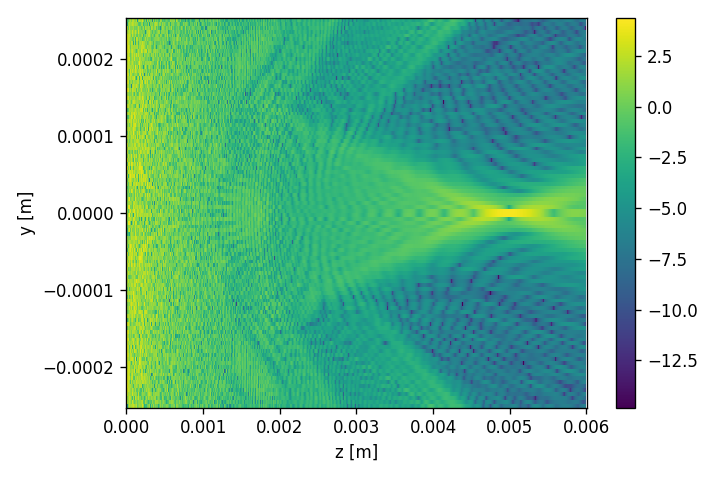

In [21]:
fig = plt.figure() 

plt.pcolormesh(zp2,yp2,np.log(np.abs(z2)**2) )
plt.colorbar()
plt.xlabel("z [m]")
plt.ylabel("y [m]")
plt.tight_layout()

plt.savefig("Zoom-YZ-log-representation.png")

## Propagation from a Fresnel Zone Plate

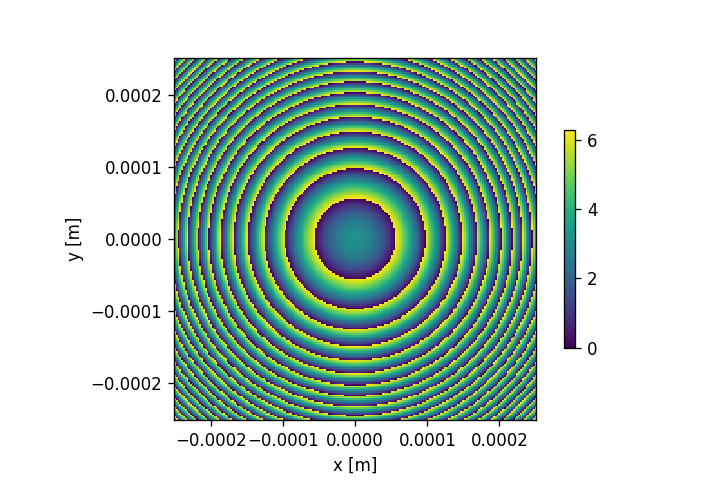

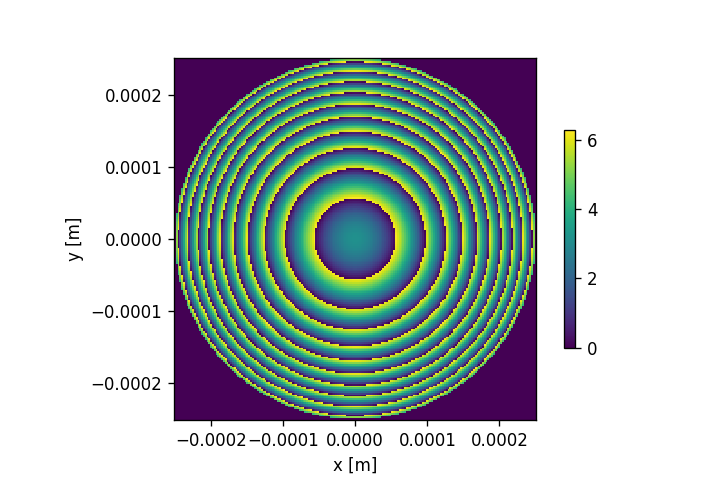

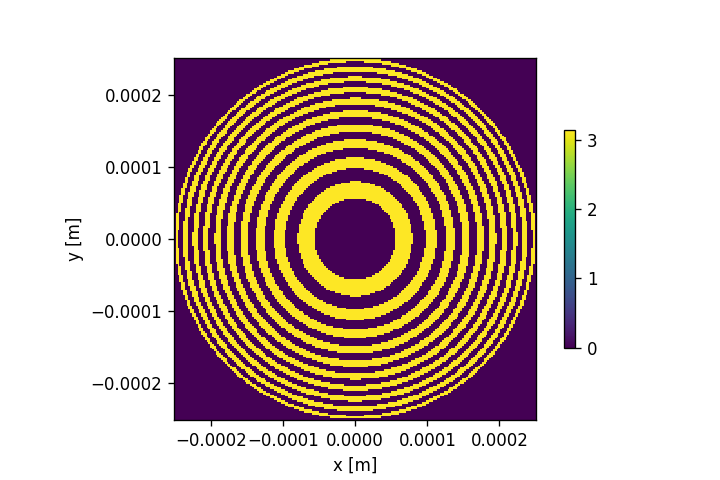

In [22]:
#### Generate a fresnel zone plate 

#number of pixels 
x_pixel = 200
y_pixel = 200

#size of the rectangular mask 
aperture_width  = 500e-6 #m
aperture_height = 500e-6

pixsize = aperture_width/x_pixel #m

wavelength = 632.8e-9 #m
focal_length = 5000e-6

zmin = wavelength
zmax = 1.2* focal_length
nzs = 256 

radius = aperture_width/2 

# Create Aperture
aperture1 = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel)

# Populate Aperture with Fresnel mask 
mask1 = moe.generate.fresnel_phase(aperture1, focal_length, wavelength )

moe.plotting.plot_aperture(mask1)


##############
###Fresnel mask with a truncated circular aperture 

# Create empty mask
aperture2 = moe.generate.create_empty_aperture_from_aperture(aperture1)

# and truncate around radius
mask2 = moe.generate.fresnel_phase(aperture2, focal_length, wavelength, radius=radius)
moe.plotting.plot_aperture(mask2)

# Discretize mask in number of levels
# Select exact position of contours  in phase
phase_vals = [ 0, np.pi]

mask2.discretize(np.array( phase_vals)[:] ) 
moe.plotting.plot_aperture(mask2)


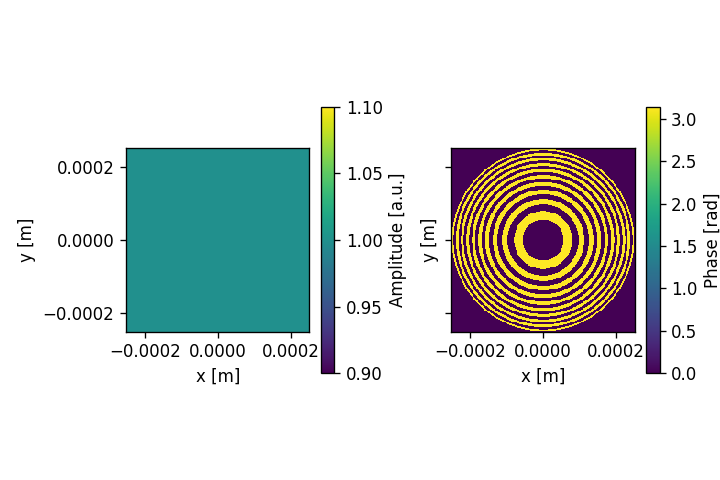

In [23]:
# Generate a uniform field
field = moe.field.create_empty_field_from_aperture(mask2)

field = moe.field.generate_uniform_field(field, E0=1)

# Modulates the field 
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask2)

# Plots the field (amplitude and phase)
moe.plotting.plot_field(field)

plt.tight_layout()
plt.show()


[########################################] | 100% Completed |  1.3s


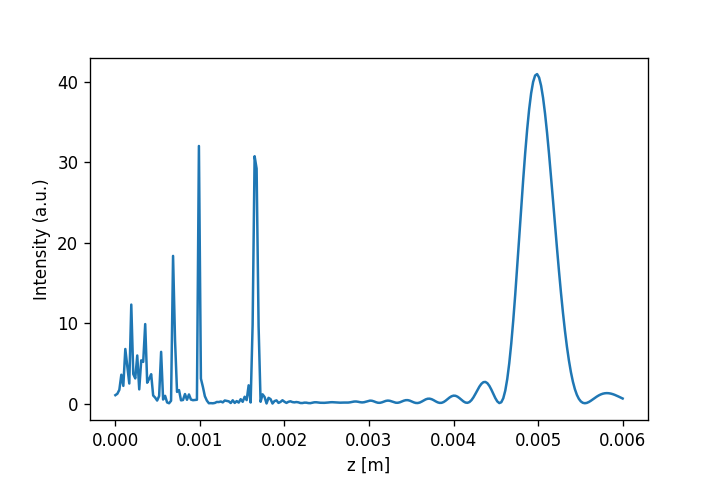

In [24]:
# Propagates the field in a single line along the Z axis
screen_ZZ = moe.field.create_screen_ZZ(zmin, zmax, nzs)
E_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength)

# Get the intensity 
I_ZZ = E_ZZ.amplitude[0,0,:]**2


# Plot the intensity 
fig = plt.figure() 

zp = np.linspace(zmin,zmax,nzs)

plt.plot(zp, I_ZZ)
plt.xlabel("z [m]")
plt.ylabel("Intensity (a.u.)")

plt.savefig("FZP-Zprop.png")

In [25]:
#### Propagate field and calculate in plane YZ, using 100 bins in Y

nbins_y= x_pixel

# Creates YZ screen
screen_YZ = moe.field.create_screen_YZ(-aperture_height/2, aperture_height/2, nbins_y, 
                                        zmin, zmax, nzs,
                                        x=0)

# Propagate the field 
E_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, simp2d=True)


[########################################] | 100% Completed |  3min 14.0s


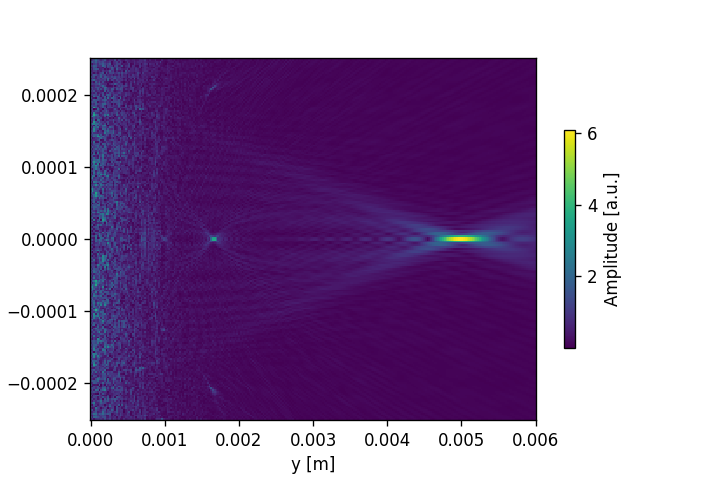

<Figure size 720x480 with 0 Axes>

In [26]:
#Plot the amplitude of the propagated field in yz screen
moe.plotting.plot_screen_YZ(E_YZ, which='amplitude')
plt.show()

plt.savefig("FresnelN2-YZ.png")

## Propagation from a Spiral Phase Plate

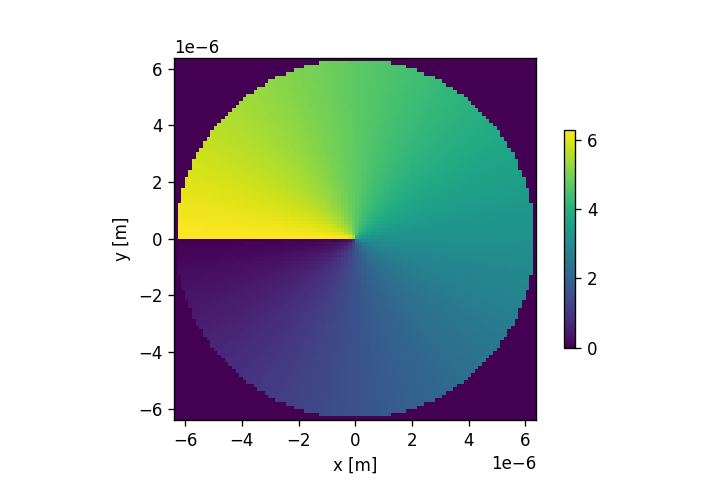

In [27]:
### Spiral Phase plate 

npix = 100 # nr of pixels 

wavelength = 632.8e-9 #wavelength in m 
z_distance = 100*wavelength # propagation distance

aperture_width = 20*wavelength  #x-size in m 
aperture_height = 20*wavelength #y-size in m

pixsize = aperture_width/npix

ltop = 1 #topological number

#spiral mask is defined as  
#spiral(x,y,x0,y0,ltop)
    
def spiral(x,y,x0,y0,L):
    """
    returns a spiral COMPLEX PHASE with input meshgrid (x,y) with center at (x0,y0)
    x = x array from meshgrid 
    y = y array from meshgrid 
    x0 = x-coordinate of center of the lens 
    y0 = y-coordinate of center of the lens
    L = topological charge 
    """

    theta = np.arctan2((y-y0),(x-x0))
    sp = np.exp(1.0j*L*theta)
    return sp
    

n =10 # number of gray levels 

center = (0, 0)

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, npix, -aperture_height/2, aperture_height/2, npix)
mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.spiral, center=center, L=ltop)
mask.aperture = mask.aperture + np.pi 

mask.aperture[np.where(mask.XX**2+mask.YY**2>(aperture_width/2)**2 ) ] = 0 
moe.plotting.plot_aperture(mask)

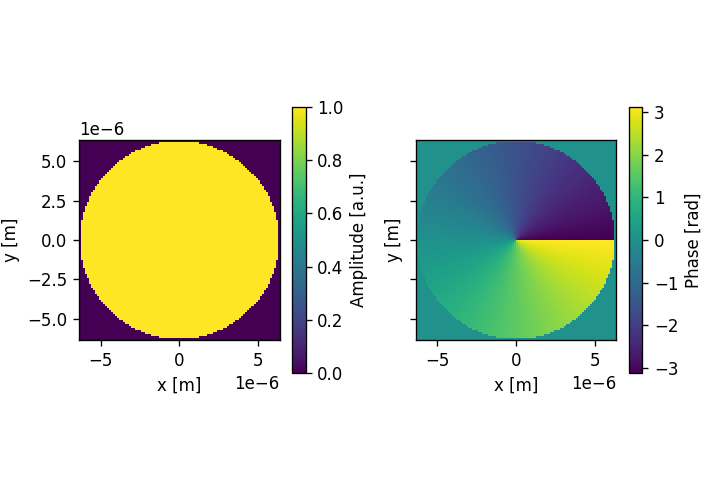

In [28]:
# Generate a uniform field
field = moe.field.create_empty_field_from_aperture(mask)

field = moe.field.generate_uniform_field(field, E0=1)

aperture = moe.generate.create_empty_aperture_from_aperture(mask)

mask_circle = moe.generate.circular_aperture(aperture, radius=aperture_width/2)

# Modulates the field 
field = moe.field.modulate_field(field, amplitude_mask=mask_circle, phase_mask=mask)

# Plots the field (amplitude and phase)
moe.plotting.plot_field(field)

plt.tight_layout()
plt.show()


In [29]:
##Propagate field in plane XY at z_distance

# Creates XY screen
screen_XY = moe.field.create_screen_XY(-aperture_width/2, aperture_width/2, npix, 
                                       -aperture_height/2, aperture_height/2, npix, 
                                        z=z_distance)

# Propagate the field
E_XY = moe.propagate.RS_integral(field, screen_XY, wavelength, simp2d=True)


[########################################] | 100% Completed | 16.0s


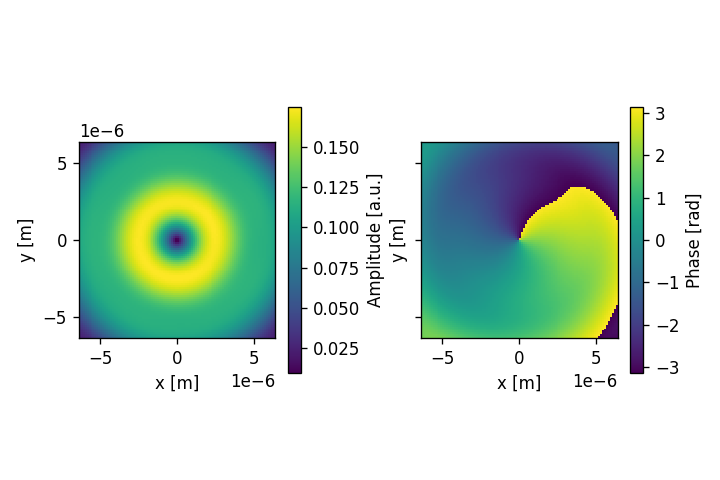

<Figure size 720x480 with 0 Axes>

In [30]:
# Plot the amplitude of the propagated field in XY screen

moe.plotting.plot_screen_XY(E_XY)
#plt.title("z = "+str(z_distance)+" m")

plt.tight_layout()
plt.show()

plt.savefig("Spiral-N16-XY.png")

In [31]:
#### Propagate field and calculate in plane YZ

nbins_y = x_pixel
zmin = wavelength 
zmax = 2 * z_distance
nzs = 500 

# Creates YZ screen
screen_YZ = moe.field.create_screen_YZ(-aperture_height/2, aperture_height/2, nbins_y, 
                                        zmin, zmax, nzs,
                                        x=0)

# Propagate the field 
E_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, simp2d=True)


[########################################] | 100% Completed |  2min 31.5s


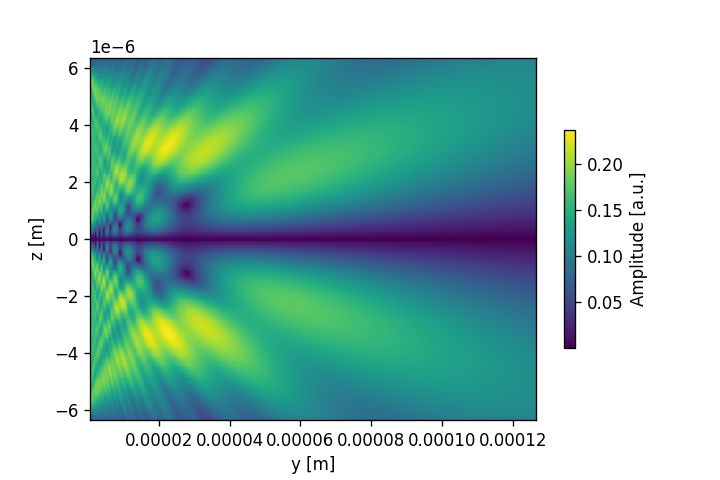

<Figure size 720x480 with 0 Axes>

In [32]:
#Plot the amplitude of the propagated field in yz screen
moe.plotting.plot_screen_YZ(E_YZ, which='amplitude')
plt.show()


plt.savefig("Spiral-YZ.png")

## Propagation from Alvarez Lenses Pair

In [59]:
# Creates an Alvarez lens pair masks
# evaluates the produced focal spot by the displaced lenses using the propagation
aperture_width = 1000*micro
aperture_height = 500*micro
x_pixel = 1000
y_pixel = 500


# focal range of the Alvarez lenses
f1 = 500*micro
f2 = 15000*micro
tuning_distance = 100*micro
wavelength = 1550*nano

#nr of levels 
n = 8

# First lens
aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)
lens1 =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.Alvarez_phase, f1=f1, f2=f2, tuning_distance=tuning_distance, wavelength=wavelength)

lens1.modulos(2*np.pi)
lens1.discretize(n)

# Second lens which is the same but flipped.
aperture2 = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)

lens2 =  moe.generate.arbitrary_aperture_function(aperture2, moe.sag.Alvarez_phase, f1=f1, f2=f2, tuning_distance=tuning_distance, wavelength=wavelength)
lens2.aperture = np.fliplr(lens2.aperture)

lens2.modulos(2*np.pi)
lens2.discretize(n)

# initializes an aperture to store the result
result = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)


# displace aperture equally both ways, total displacement is twice displacement
displacement = 12*micro
rollidx = int(np.round(displacement/lens1.pixel_x,))

roll = rollidx
lens1.aperture = np.roll(lens1.aperture, -roll, axis=1)
lens2.aperture = np.roll(lens2.aperture, roll, axis=1)

lens1.aperture[:,-roll:] = 0
lens2.aperture[:,:roll] = 0


# Calculates the resulting aperutre by the sum of both displaced lens1 and lens2
result.aperture = -lens1.aperture - lens2.aperture

result.modulos(2*np.pi)

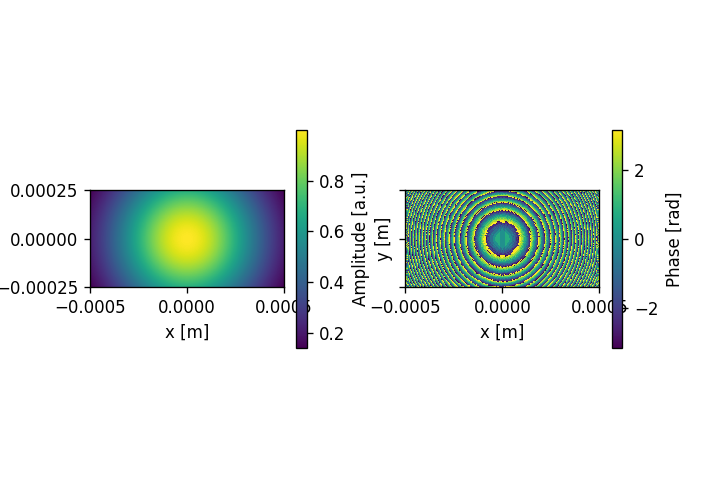

In [61]:
# Creates a mask from the result, and modulates the phase of a gaussian field

mask = result
field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_gaussian_field(field, E0=1, w0=400*micro)

field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)

moe.plotting.plot_field(field)


[########################################] | 100% Completed | 11min  8.8s


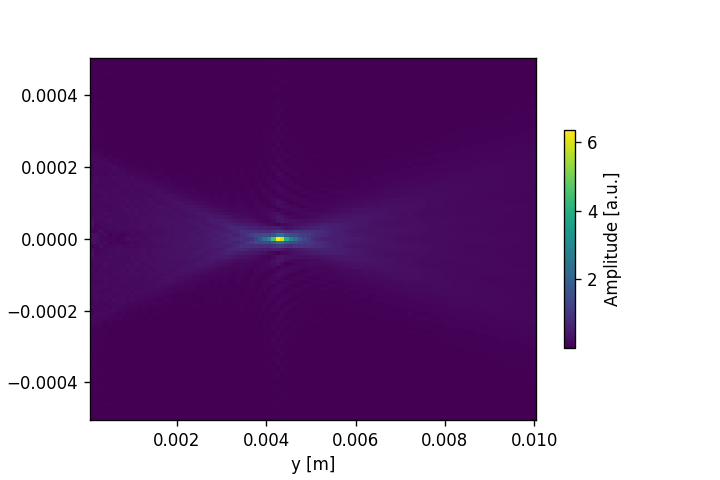

In [62]:
screen_YZ = moe.field.create_screen_YZ(-500*micro,500*micro, 101, 100*micro, 10000*micro, 101)
E_YZ = moe.propagate.RS_integral(field, screen_YZ, wavelength, )

moe.plotting.plot_screen_YZ(E_YZ, which='amplitude')

[########################################] | 100% Completed | 13.0s


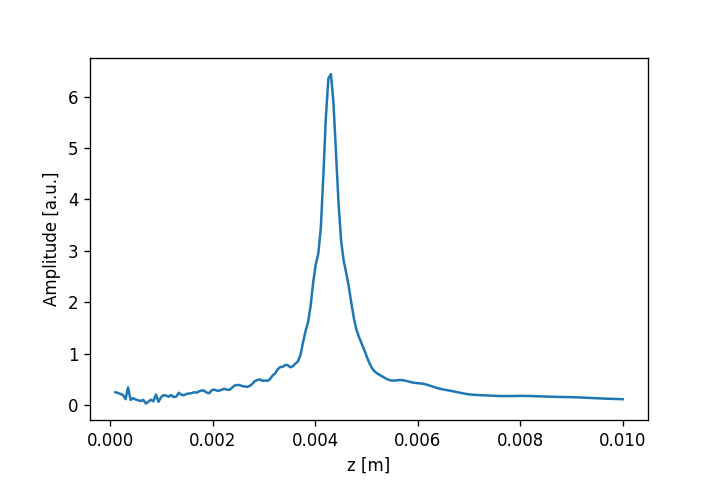

In [63]:
screen_ZZ = moe.field.create_screen_ZZ(100*micro, 10000*micro, 201)
E_ZZ = moe.propagate.RS_integral(field, screen_ZZ, wavelength)

moe.plotting.plot_screen_ZZ(E_ZZ, which='amplitude')

[########################################] | 100% Completed |  1min  4.2s


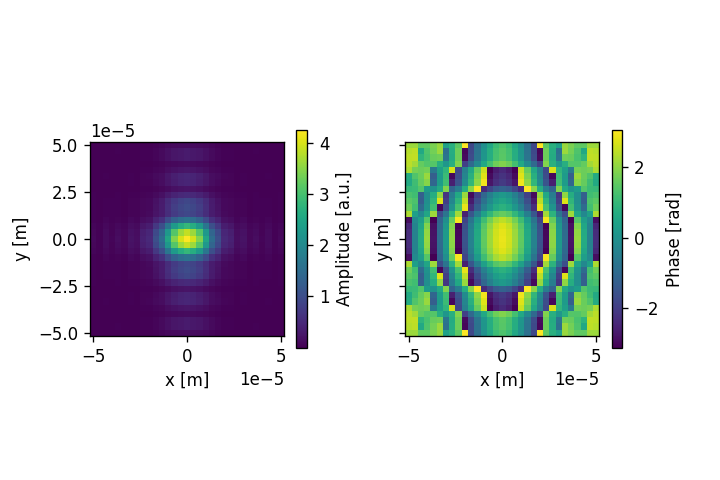

In [65]:
screen_XY = moe.field.create_screen_XY(-50*micro,50*micro, 31, 
                                        -50*micro,50*micro, 31, 
                                        z=4150*micro)

E_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(E_XY)

## Propagation from Dammann Gratings

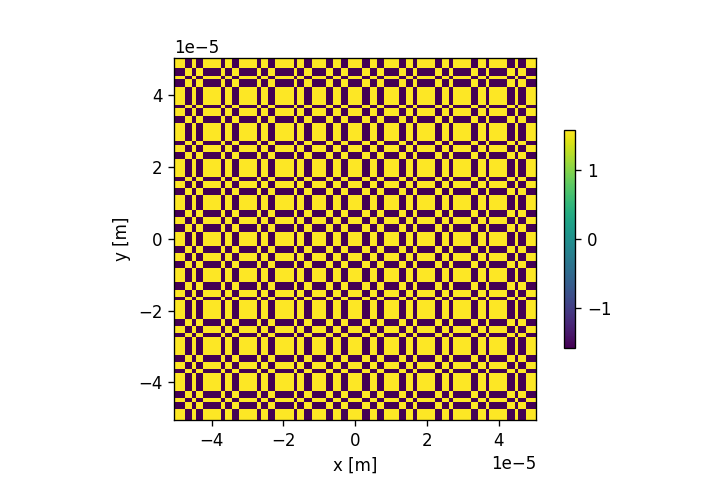

In [66]:
# Generates and propagates a Dammann grating phase 

aperture_width = 100*micro
aperture_height = 100*micro
x_pixel = 100
y_pixel = 100

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)


transitions_x = [0.242, 0.414]
transitions_y = [0.242, 0.414]


period_x = period_y = 10*micro


mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.dammann_2d, transitions_x=transitions_x, period_x=period_x, transitions_y=transitions_y, period_y=period_y)

mask.aperture = mask.aperture*np.pi/2

moe.plotting.plot_aperture(mask)

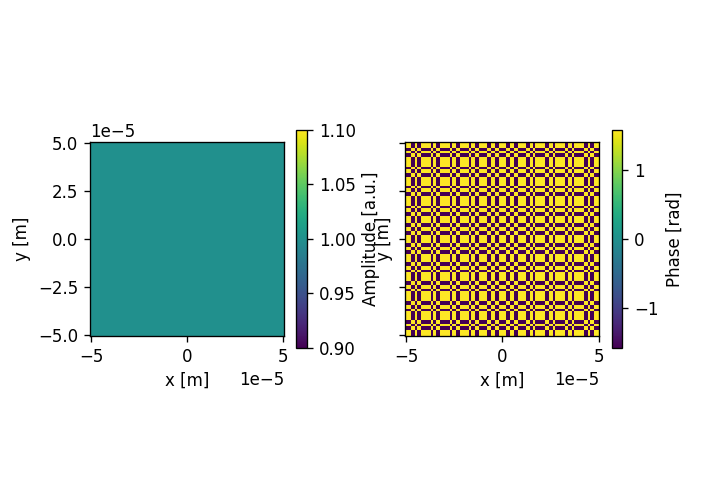

In [67]:
field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_uniform_field(field, E0=1)


field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)


moe.plotting.plot_field(field)

[########################################] | 100% Completed |  2min  9.4s


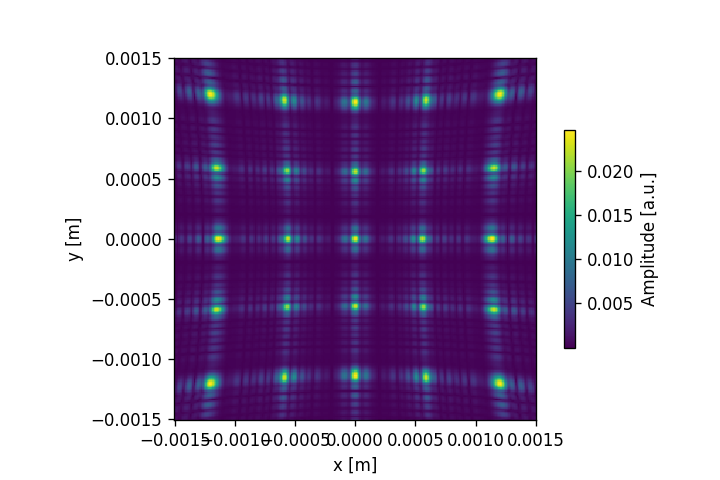

In [68]:
# define the wavelength used in the propagation
wavelength = 1550*nano

# Define the screen size and create it
screen_width = 3000*micro
screen_height = 3000*micro
x_pixel =256
y_pixel = 256

screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=3500*micro)

E_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(E_XY, which='amplitude')

Text(0.5, 0, 'Amplitude [a.u.]')

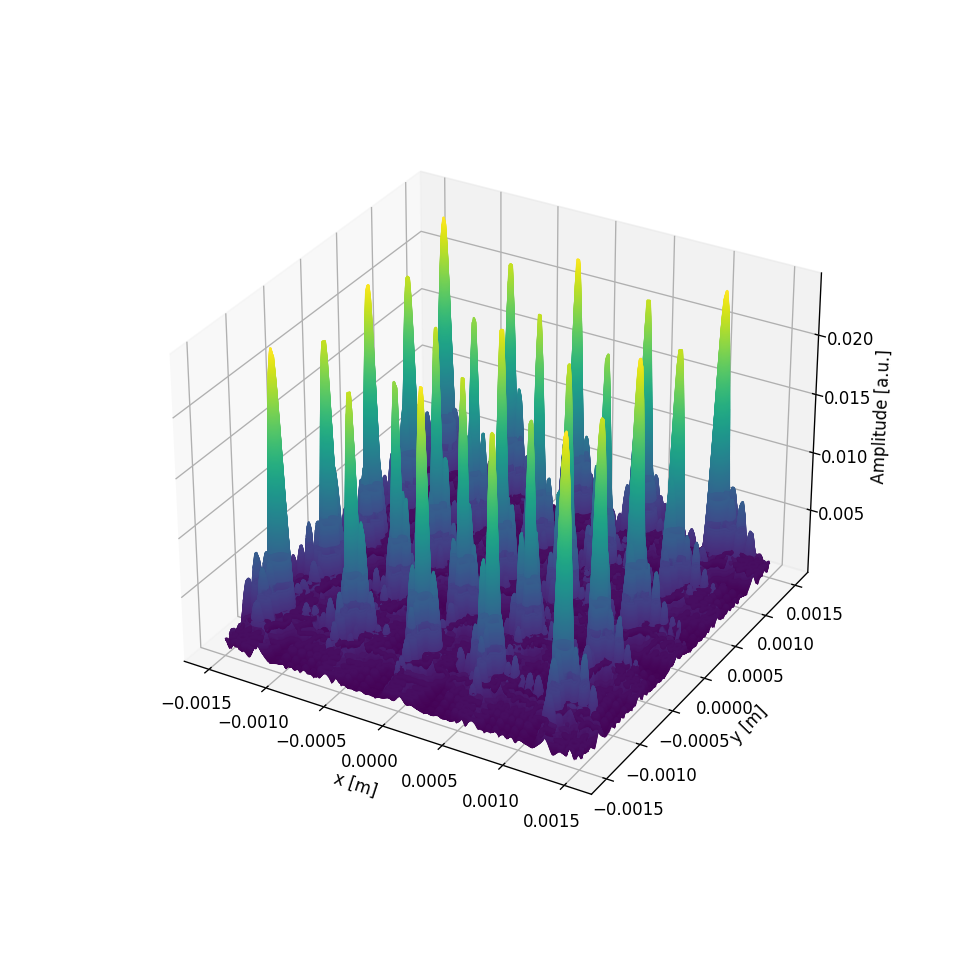

In [69]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection='3d')

x = E_XY.x
y = E_XY.y
z = E_XY.amplitude[:,:,0]

#ax.plot(x,y,z)

ax.contour3D(x,y,z,1000)
#ax.plot_surface(x,y,z)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("Amplitude [a.u.]")

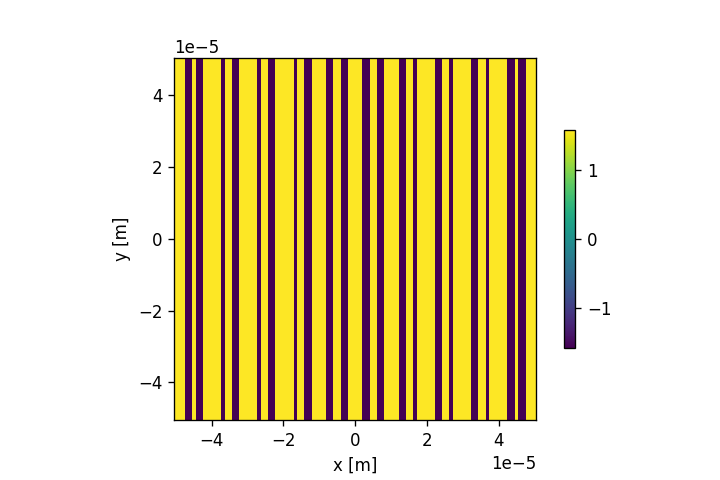

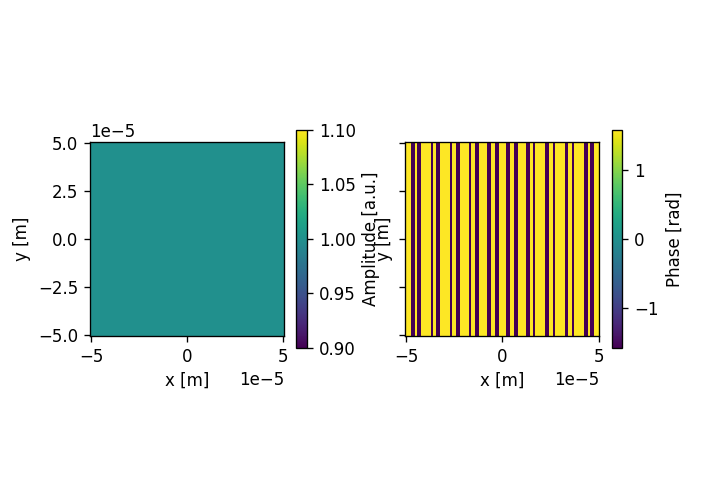

In [70]:
# Generates and propagates a Dammann grating phase 

aperture_width = 100*micro
aperture_height = 100*micro
x_pixel = 100
y_pixel = 100

aperture = moe.generate.create_empty_aperture(-aperture_width/2, aperture_width/2, x_pixel, -aperture_height/2, aperture_height/2, y_pixel,)


transitions_x = [0.132, 0.48]
transitions_x = [0.242, 0.414]
#transitions_x = [0.1, 0.136,0.37, 0.498]
#transitions_y = [0.1, 0.3]
transitions_y = None

period_x = period_y = 10*micro

# mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.dammann_2d, L=L)
mask =  moe.generate.arbitrary_aperture_function(aperture, moe.sag.dammann_2d, transitions_x=transitions_x, period_x=period_x, transitions_y=transitions_y, period_y=period_y)

mask.aperture = mask.aperture*np.pi/2


moe.plotting.plot_aperture(mask)


field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_uniform_field(field, E0=1)
# field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=None)
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)


moe.plotting.plot_field(field)

[########################################] | 100% Completed |  2min  2.2s


Text(0, 0.5, 'Amplitude [a.u.]')

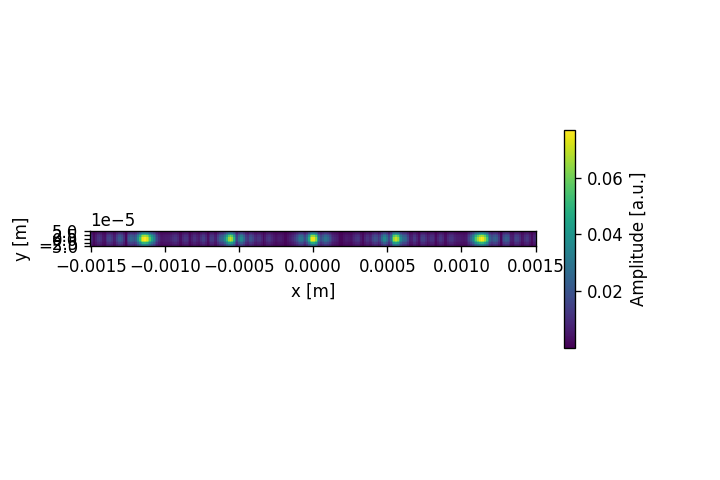

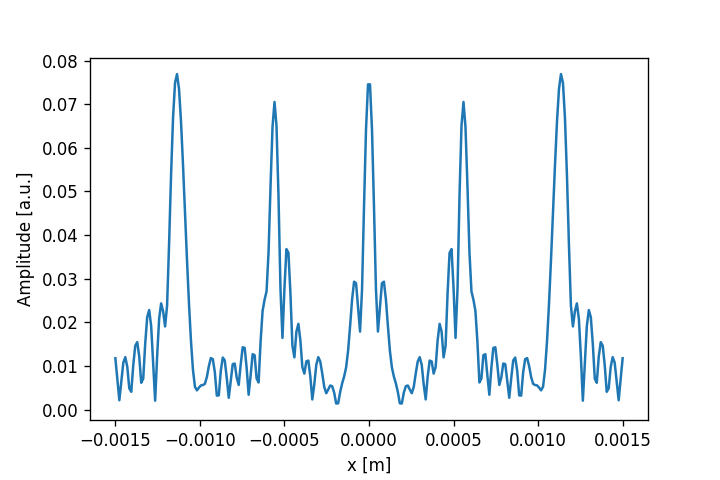

In [71]:
# define the wavelength used in the propagation
wavelength = 1550*nano

# Define the screen size and create it
screen_width = 3000*micro
screen_height = 3000*micro
x_pixel =256
y_pixel = 256

screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=3500*micro)

E_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(E_XY, which='amplitude')
plt.ylim(-aperture_height/2, aperture_height/2)

fig = plt.figure() 

xmat= E_XY.amplitude[:,:,0]
y= xmat[int(xmat.shape[0]/2),:]
x = E_XY.x

plt.plot(x,y)
plt.xlabel("x [m]")
plt.ylabel("Amplitude [a.u.]")

## Propagation from Computer Generated Holograms 

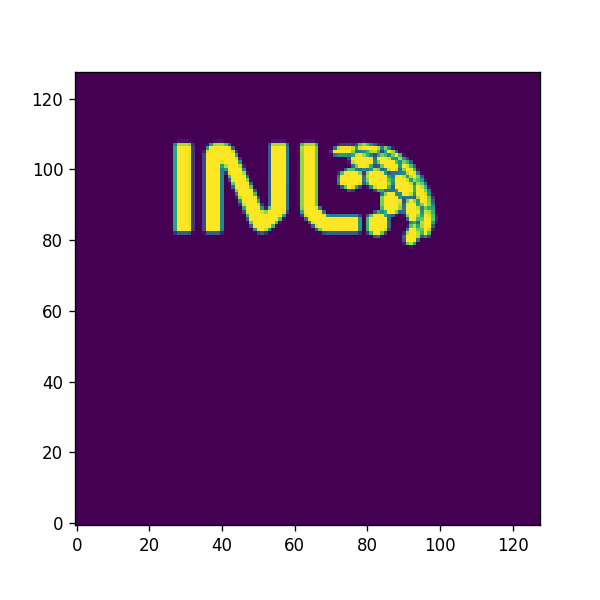

In [3]:
from PIL import Image, ImageOps
file = "../5 - Holograms/target.png"

target = Image.open(file).convert("L")
target = ImageOps.flip(target)

size = 128
target = target.resize((size,size))
target = np.array(target)/255

fig = plt.figure(figsize=(5,5))
x = np.arange(0,size)
y = np.arange(0,size)
plt.pcolormesh(x,y,target)

Progress: [####################] 100.0%
[Gerchberg Saxton Algorithm]
Elapsed: 0:00:00.348025


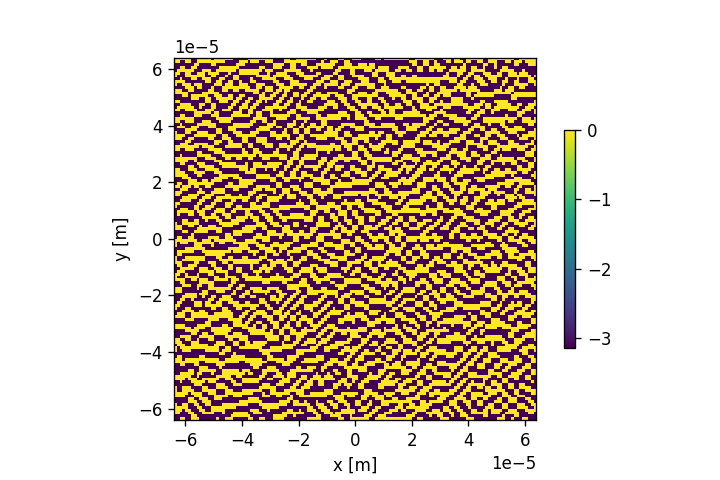

In [4]:
# Binary level phase mask
levels = 2

iterations = 20

levels = moe.utils.create_levels(-np.pi, np.pi, levels,)
phase_mask, errors = moe.holograms.algorithm_Gerchberg_Saxton(target, iterations=iterations, levels=levels)

phase_mask = moe.holograms.correct_mask_shift(phase_mask)
mask = moe.generate.create_aperture_from_array(phase_mask, pixel_size=(1*micro, 1*micro), center=True, )


# Discretize to same levels as original
mask.discretize(levels)
moe.plotting.plot_aperture(mask)

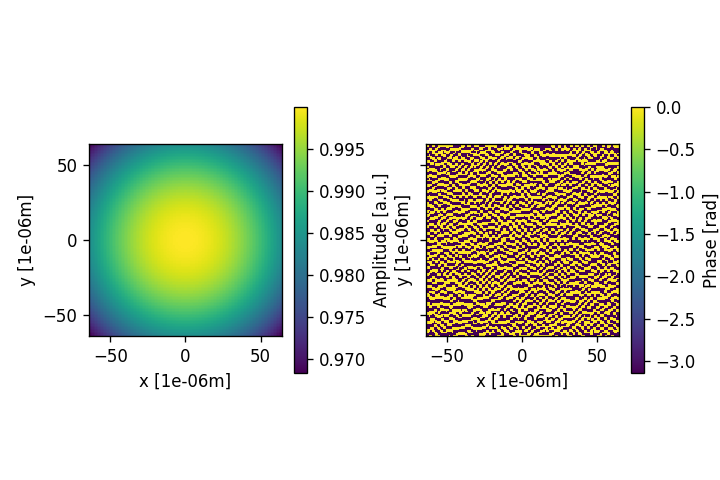

In [5]:
# Create the gaussian field to propagate through the hologram

field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_gaussian_field(field, E0=1, w0=500*micro)
# field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=None)
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)

moe.plotting.plot_field(field, scale=micro)
plt.tight_layout()

[########################################] | 100% Completed |  1min 51.0s


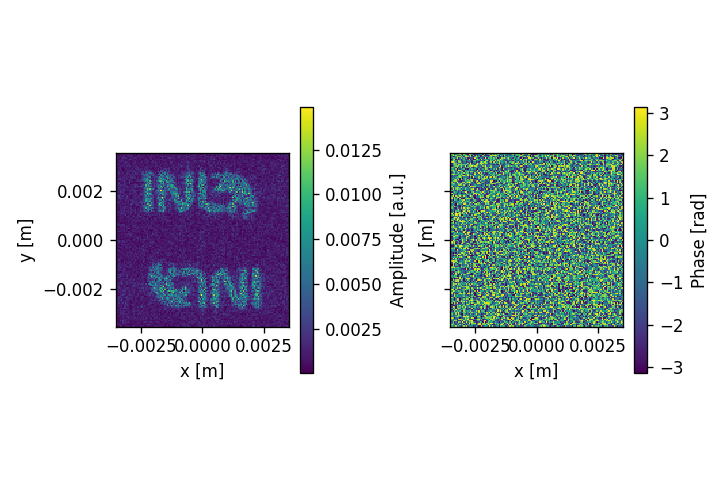

In [6]:
# define the wavelength used in the propagation
wavelength = 532*nano

# Define the screen size and create it
screen_width = 7000*micro
screen_height = 7000*micro
x_pixel = 128
y_pixel = 128

screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=15000*micro)

screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(screen_XY)
plt.tight_layout()

Progress: [####################] 100.0%
[Gerchberg Saxton Algorithm]
Elapsed: 0:00:00.508610


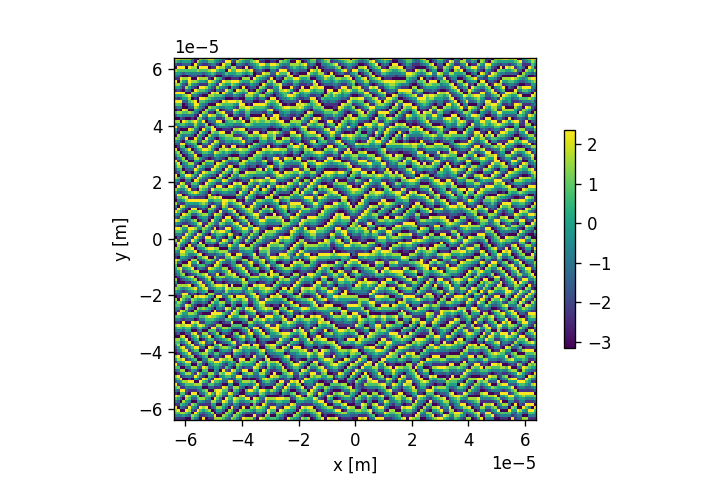

[########################################] | 100% Completed |  1min 28.2s


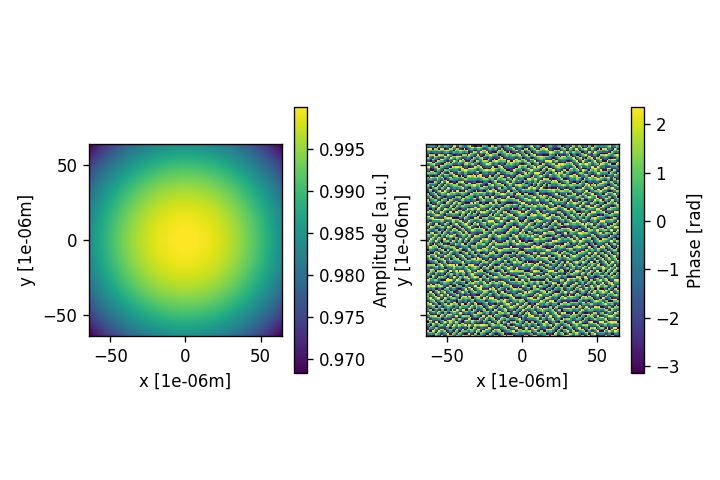

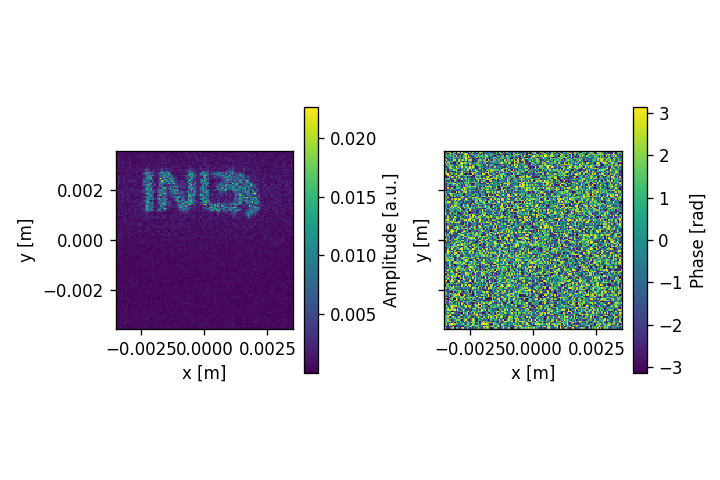

In [7]:
# Multilevel phase hologram
levels = 8

iterations = 20

levels = moe.utils.create_levels(-np.pi, np.pi, levels,)
phase_mask, errors = moe.holograms.algorithm_Gerchberg_Saxton(target, iterations=iterations, levels=levels)

phase_mask = moe.holograms.correct_mask_shift(phase_mask)
mask = moe.generate.create_aperture_from_array(phase_mask, pixel_size=(1*micro, 1*micro), center=True, )


# Discretize to same levels as original
mask.discretize(levels)
moe.plotting.plot_aperture(mask)

# Create the gaussian field to propagate through the hologram
field = moe.field.create_empty_field_from_aperture(mask)
field = moe.field.generate_gaussian_field(field, E0=1, w0=500*micro)
# field = moe.field.modulate_field(field, amplitude_mask=mask, phase_mask=None)
field = moe.field.modulate_field(field, amplitude_mask=None, phase_mask=mask)


moe.plotting.plot_field(field, scale=micro)
plt.tight_layout()



# define the wavelength used in the propagation
wavelength = 532*nano

# Define the screen size and create it
screen_width = 7000*micro
screen_height = 7000*micro
x_pixel = 128
y_pixel = 128

screen_XY = moe.field.create_screen_XY(-screen_width/2, screen_width/2, x_pixel,
                                     -screen_height/2, screen_height/2, y_pixel, 
                                     z=15000*micro)

screen_XY = moe.propagate.RS_integral(field, screen_XY, wavelength)

moe.plotting.plot_screen_XY(screen_XY)
plt.tight_layout()
